# Import

In [313]:
import os, sys

import pandas as pd
import polars as pl
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import sklearn
import lightgbm as lgb
import catboost as cb
import xgboost as xgb

import dproc, sgml, sgnn, sgutil

print(sys.version)

for i in [pd, pl, np, mpl, sns, lgb, cb, xgb]:
    try:
        print(i.__name__, i.__version__)
    except:
        pass

3.12.6 (main, Sep 30 2024, 02:19:13) [GCC 9.4.0]
pandas 2.2.3
polars 1.12.0
numpy 1.26.4
matplotlib 3.8.4
seaborn 0.13.2
catboost 1.2.5
xgboost 2.1.2


In [68]:
for i in ['data', 'result', 'model', 'img']:
    if not os.path.exists(i):
        os.mkdir(i)

data_path = 'data'
def  get_data_path(name):
    return os.path.join(data_path, name)

if not os.path.exists(get_data_path('train.csv')):
    !kaggle competitions download -c playground-series-s4e8
    !unzip playground-series-s4e8.zip -d data

sc = sgutil.SGCache('img', 'result')

In [4]:
if not os.path.exists(get_data_path('train.parquet')):
    df_type = dproc.merge_type_df(
        [pl.scan_csv(get_data_path(i)).pipe(dproc.get_type_df) for i in ['train.csv', 'test.csv']]
    )
    pl_type = dproc.get_type_pl(df_type)
    pl.scan_csv(get_data_path('train.csv'), schema_overrides =  pl_type).sink_parquet(
        get_data_path('train.parquet')
    )
    pl.scan_csv(get_data_path('test.csv'), schema_overrides =  pl_type).sink_parquet(
        get_data_path('test.parquet')
    )
    df_type['dtype'] = df_type.index.to_series().map(pd.Series(pl_type).astype(str))
    pd_vars = dproc.PD_Vars(get_data_path('var'), df_type)
    pd_vars.save()
pd_vars = dproc.PD_Vars.load(get_data_path('var'))

In [275]:
target = 'class'
df_train = pd.read_parquet(get_data_path('train.parquet')).set_index('id')
df_test = pd.read_parquet(get_data_path('test.parquet')).set_index('id')
df_train[target] = df_train[target] == 'p'

class가 'p' 이면 True 'n' 이면 False로 바꿉니다. 

In [276]:
X_cat = pd_vars.df_var.drop(index = [target]).query('dtype == "Categorical" and src == "org"').index.tolist()
X_num = pd_vars.df_var.drop(index = [target, 'id']).loc[
    pd_vars.df_var['dtype'].str.startswith('Float')
].index.tolist()

In [277]:
df_train.shape, df_test.shape

((3116945, 21), (2077964, 20))

# Target

In [278]:
pd.concat([
    df_train[target].value_counts().rename('count'),
    df_train[target].value_counts(normalize=True).rename('ratio')
], axis = 1)

,count,ratio
class,,
True,1705396,0.547137
False,1411549,0.452863


# Categorical Variables

모두 명목형 변수로 보이고, 모든 변수가 노이즈를 포함하고 있으며, 노이즈 변수는 빈도수가 낮은 변수들로 보입니다.

이를 정리해주는 청소 작업이 필요합니다.

## Cleaning data

In [279]:
def get_clean_cat(df, v, min_freq = 100):
    desc = {
        i + '_c': 'Cleaned: {}, frequency less than {}'.format(i, min_freq) for i in v
    }
    c_types = {
        i: pd.CategoricalDtype(['Unk'] + df[i].value_counts().pipe(lambda x: x.loc[x >= 100]).index.tolist())
        for i in v
    }
    
    return lambda x: pd.concat([
        dproc.rearrange_cat(x[i], c_types[i], lambda d, c: 0 if c not in d else c, use_set = True).fillna('Unk').rename(i + '_c')
        for i in v
    ], axis = 1), desc

df_train = pd_vars.put_proc('clean_cat', df_train, [get_clean_cat(df_train, X_cat)])
X_cat_c = pd_vars.df_var.query('src == "clean_cat"').index.tolist()

## Descriptive

In [280]:
from scipy.stats import chi2_contingency

In [281]:
sc.cache_result(
    'cat_desc',
    lambda : pd.concat([
        (df_train[X_cat_c] == 'Unk').sum().rename('Missing'),
        (df_train[X_cat_c] == 'Unk').mean().rename('Missing_ratio'),
        df_train[X_cat_c].nunique().rename('nunique'),
        df_train[X_cat_c].apply(
            lambda x: pd.Series(chi2_contingency(pd.crosstab(index = x, columns = df_train[target]))[:2], index = ['chi2, stat', 'chi2, pvalue'])
        ). T
    ], axis = 1), rerun = 0
).sort_values(['chi2, pvalue', 'chi2, stat'], ascending = [True, False])

,Missing,Missing_ratio,nunique,"chi2, stat","chi2, pvalue"
cap-color_c,367,0.000118,13,208330.048329,0.0
stem-color_c,296,0.000095,14,206349.730967,0.0
cap-surface_c,671625,0.215475,12,199214.334867,0.0
gill-attachment_c,524437,0.168254,8,169650.568106,0.0
stem-surface_c,1981257,0.635641,9,165511.927295,0.0
gill-color_c,492,0.000158,13,150857.465308,0.0
ring-type_c,129280,0.041477,9,127860.755061,0.0
stem-root_c,2757206,0.884586,6,99375.801637,0.0
habitat_c,492,0.000158,9,98305.661513,0.0
veil-color_c,2741088,0.879415,7,92323.784213,0.0


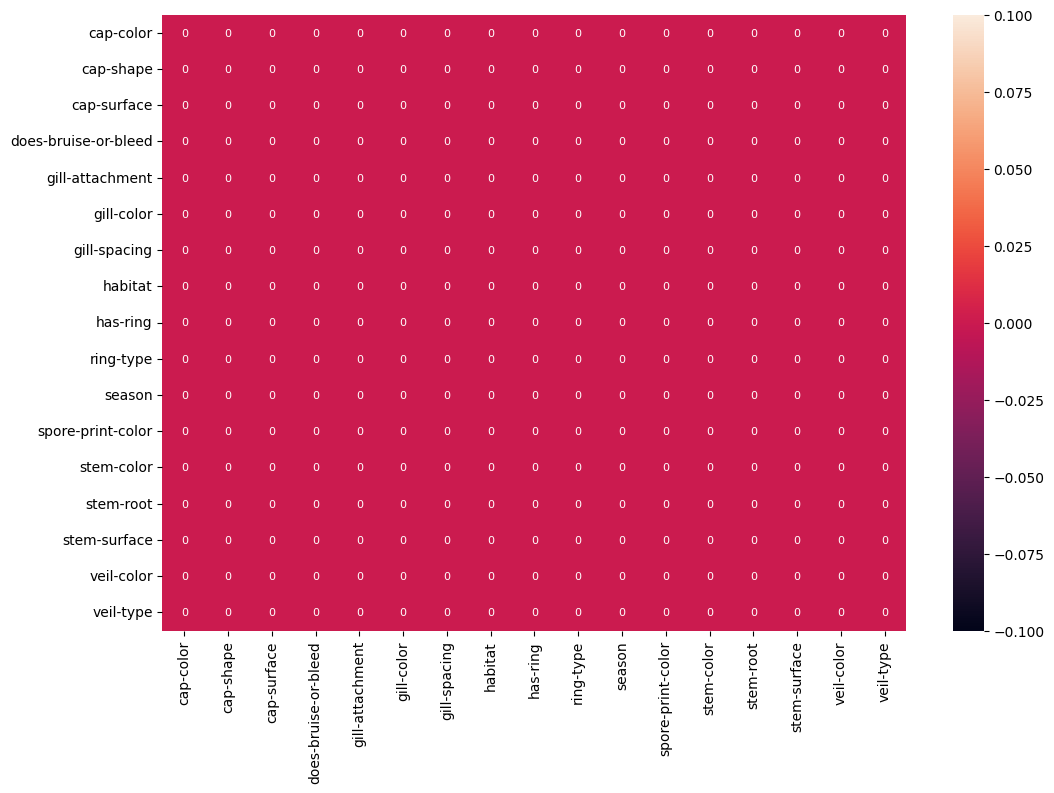

In [282]:
from scipy.spatial.distance import pdist, squareform
plt.figure(figsize = (12, 8))
sns.heatmap(
    pd.DataFrame(
        squareform(
            sc.cache_result(
                'chi2_cat_var',
                lambda : pdist(df_train[X_cat_c].T, lambda u, v: chi2_contingency(pd.crosstab(index=u, columns=v))[1]),
                rerun = 0
            )
        ), index = X_cat, columns = X_cat
    ), annot = True, annot_kws = {'size': 8}
)
plt.show()

모든 속성이 연관성이 높습니다.

범주형 변수의 가짓수에 비해 등장하는 종류는 적습니다.

In [283]:
df_train[X_cat_c].nunique().prod()

128184423284736

In [284]:
df_train[X_cat_c].value_counts().size

108911

# Numeric Variables

In [285]:
def get_fillna_num(df, X):
    desc = {
        i : '{}, fill na with mode'.format(i) for i in X
    }
    m = df.apply(lambda x: x.mode()[0])
    return lambda x: pd.concat([
        x[i].fillna(m[i])
        for i in X
    ], axis=1), desc
df_train = pd_vars.put_proc('org', df_train, [get_fillna_num(df_train, ['cap-diameter', 'stem-height'])])

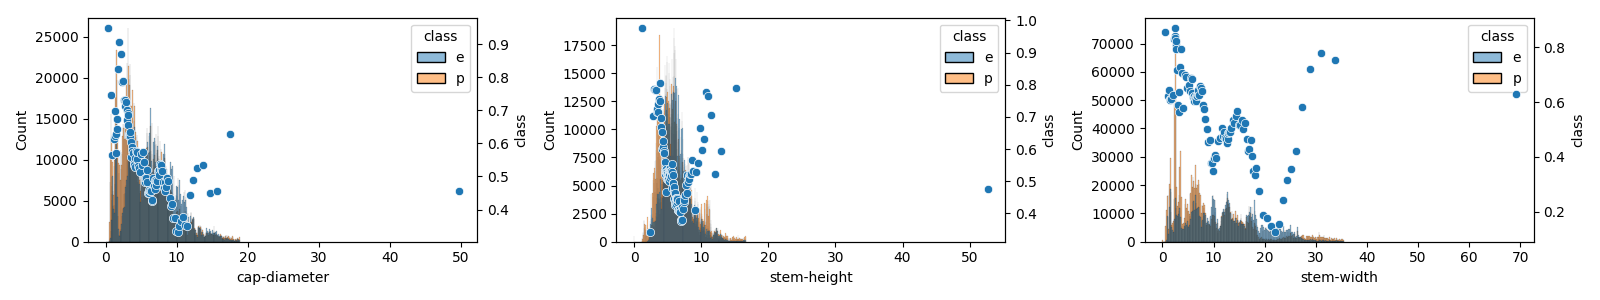

In [286]:
def plot_hist(axes):
    for i, ax in zip(X_num, axes):
        sns.histplot(df_train.loc[df_train[i] < df_train[i].quantile(0.99)], x = i, hue = target, ax=ax)
        df_train.groupby(pd.qcut(df_train[i], q = 100).map(lambda x: (x.left + x.right) / 2), observed=True)[target].mean().pipe(
            lambda x: sns.scatterplot(x, ax = ax.twinx())
        )
sc.cache_fig(
    'hist_num', plot_hist, 1, 3, figsize = (16, 3), redraw = 0
)

In [287]:
pd_vars.df_var.loc[X_num]

,na,count,n_unique,dtype,src,Description,min,max,f32,i32,i16,i8
cap-diameter,0.0,3116945.0,3913.0,Float32,org,"cap-diameter, fill na with mode",0.03,80.669998,True,True,True,True
stem-height,0.0,3116945.0,2749.0,Float32,org,"stem-height, fill na with mode",0.00,88.720001,True,True,True,True
stem-width,0.0,5194909.0,5723.0,Float32,org,None,NaN,NaN,None,None,None,None


In [288]:
df_train[X_num].corr()

,cap-diameter,stem-height,stem-width
cap-diameter,1.000000,0.364062,0.746316
stem-height,0.364062,1.000000,0.356225
stem-width,0.746316,0.356225,1.000000


# ML

## Train & Test diff 

In [289]:
from sklearn.model_selection import cross_val_score, ShuffleSplit

sc.cache_result(
    'train_test_diff',
    lambda : pd.concat([
        df_train.assign(is_train = True),
        dproc.join_and_assign(
            df_test, pd_vars.procs_all(df_test)[0]
        )[X_cat_c + X_num].assign(is_train = False)
    ], axis = 0).pipe(
        lambda x: cross_val_score(
            lgb.LGBMClassifier(random_state = 123, verbose = -1), x[X_cat_c + X_num], x['is_train'], 
            cv = ShuffleSplit(1, train_size = 0.8, random_state = 123), scoring = 'roc_auc', params = {'categorical_feature': X_cat_c}
        )
    )
)

array([0.49984168])

학습과 평가셋은 구분할 수 없습니다. 테스트셋에만 나타나는 특이 패턴은 없다고 판단 됩니다.

In [321]:
from sklearn.metrics import matthews_corrcoef
from sklearn.linear_model import LogisticRegression

def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size = validation_fraction, stratify=x[target])

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict_proba(df[X])[:, 1], index = df.index, name = 'p'),
    'score_func': lambda df, prds: matthews_corrcoef(df[target].sort_index(), (prds >= 0.5).sort_index()),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(), 
    'return_train_scores': True,
    'y': target
}

ss = ShuffleSplit(n_splits = 1, train_size = 0.6, random_state = 123)

cb_adapter = sgml.CBAdapter(cb.CatBoostClassifier)
lr_adapter = sgml.SklearnAdapter(LogisticRegression)
lgb_adapter = sgml.LGBMAdapter(lgb.LGBMClassifier)

## Analysis using CatBoost

In [345]:
from functools import partial
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import shap

In [322]:
hparams = {
    'model_params': {'n_estimators': 100, 'random_state': 123},
    'X_num': X_num, 'X_cat': X_cat_c,
    'validation_fraction': 0.1, 
}
result = sc.cache_result(
    'feature_imp_iter_cb',
    lambda : sgml.cv(
        df_train, ss, hparams, config, cb_adapter, 
        result_proc=[sgml.cb_learning_result, partial(sgml.gb_shap_learning_result, df=df_train.sample(frac=0.01, random_state= 123)), sgml.cb_interaction_importance],
        task_type = 'GPU'
    ), rerun = 1
)
result['train_scores'], result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

In [347]:
confusion_matrix(df_train.loc[result['valid_prd'].index, target], result['valid_prd'] >= 0.5)

array([[558144,   6571],
       [ 10139, 671924]])

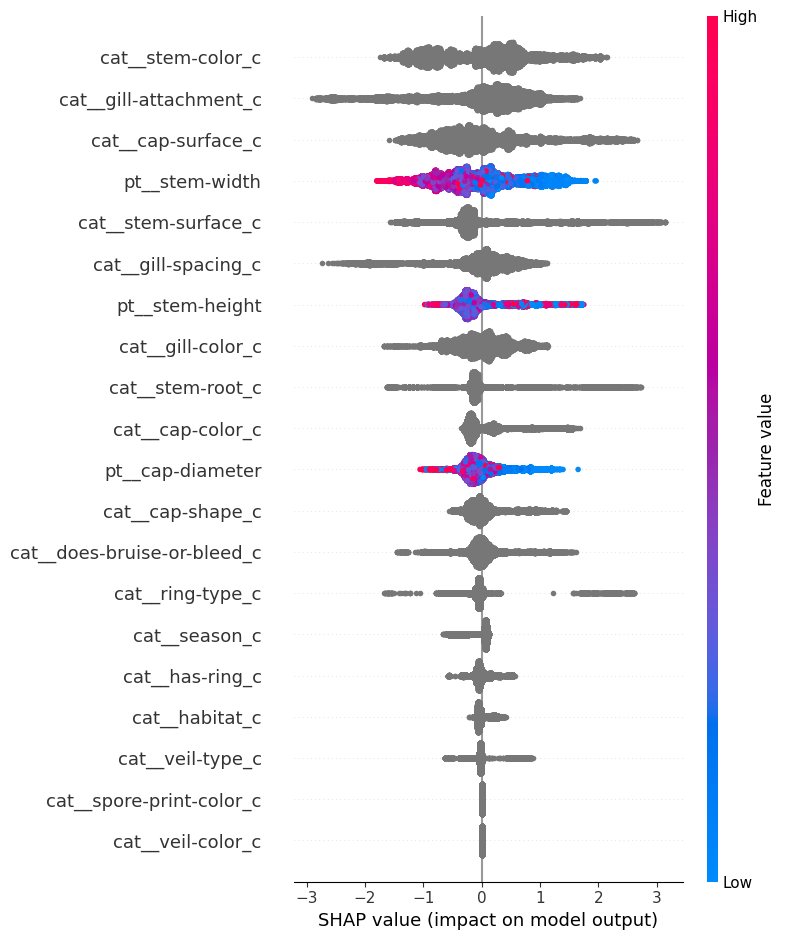

In [319]:
shap.summary_plot(result['model_result'][1]['shap_values'], result['model_result'][1]['X'])

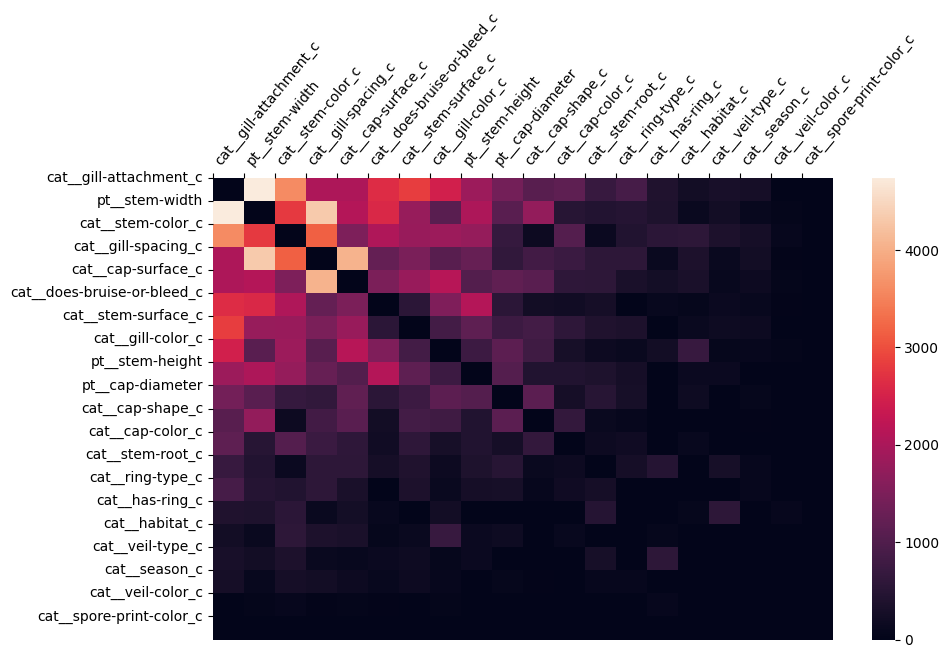

In [343]:
interaction_matrix = np.abs(result['model_result'][1]['shap_interaction_values']).sum(0)
for i in range(interaction_matrix.shape[0]):
    interaction_matrix[i, i] = 0
inds = np.argsort(-interaction_matrix.sum(0))[:20]
sorted_ia_matrix = interaction_matrix[inds, :][:, inds]
plt.figure(figsize=(10, 6))
sns.heatmap(sorted_ia_matrix)
plt.yticks(
    range(sorted_ia_matrix.shape[0]),
    result['model_result'][1]['X'].columns[inds],
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(sorted_ia_matrix.shape[0]),
    result['model_result'][1]['X'].columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

In [344]:
result['model_result'][0]['feature_importance'].sort_values(ascending=False)

cat__gill-attachment_c         13.413645
pt__stem-width                 12.242246
cat__cap-surface_c             12.199258
cat__gill-spacing_c             9.873058
cat__stem-surface_c             9.209626
cat__stem-color_c               8.992042
pt__stem-height                 5.747978
cat__does-bruise-or-bleed_c     5.087160
cat__gill-color_c               5.063659
cat__stem-root_c                3.432636
cat__ring-type_c                3.259852
pt__cap-diameter                3.140465
cat__cap-shape_c                3.013071
cat__cap-color_c                2.710818
cat__veil-type_c                0.894589
cat__habitat_c                  0.669027
cat__has-ring_c                 0.525644
cat__season_c                   0.430184
cat__veil-color_c               0.095043
cat__spore-print-color_c        0.000000
dtype: float64

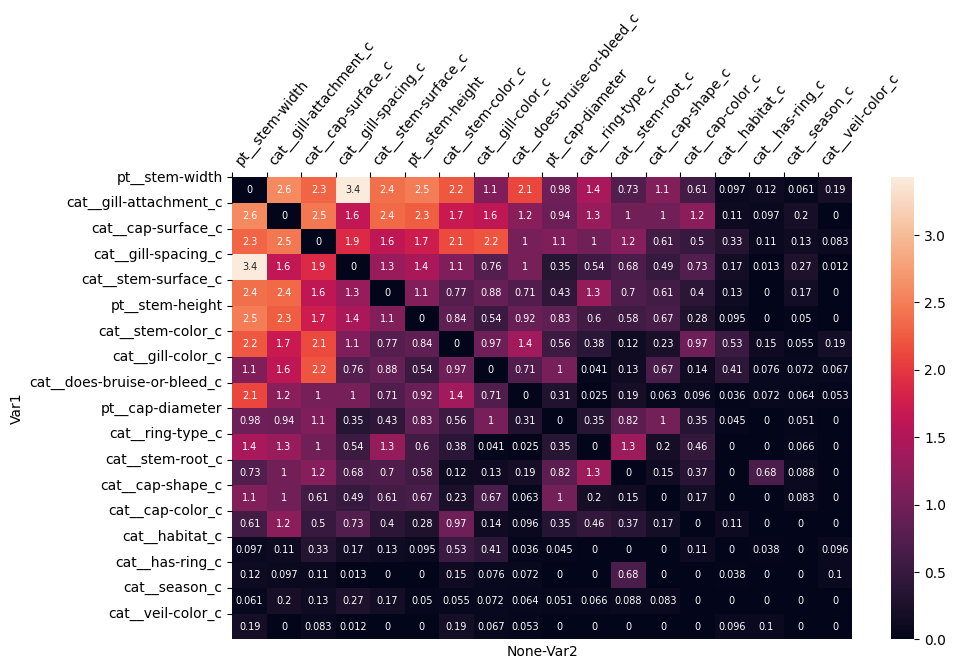

In [341]:
df_cb_inter = pd.concat([
    result['model_result'][2],
    result['model_result'][2].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 6))
sns.heatmap(df_cb_inter, annot=True, annot_kws={'size': 7})
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()